#### Date: Jun 2019<br>Programmer: Christian Dittmar, Yiğitcan Özer
This is the demo script which illustrates the main functionalities of the 'NMF toolbox'. For a detailed description we refer to [1,2] (see References below).

#### The script proceeds in the following steps:
<br>1. It loads an example audio file containing drums and melodic instruments
<br>2. It computes the STFT of the audio data.
<br>3. It applies KAM and NMF as described in [2], with random initialization of the NMF components. The final classification into harmonic and percussive is done according to the percussiveness threshold p_thresh = 0.25 as given in [2].
<br>4. It visualizes the decomposition results.
<br>5. It resynthesizes the separated audio streams and saves them as wav files to the hard drive.

#### Reference: 
[1] Christian Dittmar, Meinard Müller
<br>Reverse Engineering the Amen Break - Score-informed Separation and
<br>Restoration applied to Drum Recordings
<br>IEEE/ACM Transactions on Audio, Speech, and Language Processing,
<br>24(9): 1531-1543, 2016.
<br>[2] Christian Dittmar, Patricio López-Serrano, Meinard Müller<br>Unifying Local and Global Methods for Harmonic-Percussive Source Separation<br>In Proceedings of the IEEE International Conference on Acoustics,<br>Speech, and Signal Processing (ICASSP), 2018.

#### If you use the 'NMF toolbox' please refer to:
[3] Patricio López-Serrano, Christian Dittmar, Yiğitcan Özer, and Meinard Müller
<br>NMF Toolbox: Music Processing Applications of Nonnegative Matrix Factorization
<br>In Proceedings of the International Conference on Digital Audio Effects (DAFx), 2019.

#### License:
This file is part of 'NMF toolbox'. 'NMF toolbox' is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version. 'NMF toolbox' is distributed in the hope that it will be useful, but ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more details.

#### You should have received a copy of the GNU General Public License along<br>with 'NMF toolbox'. If not, see http://www.gnu.org/licenses/.

### Initialization

In [1]:
import os
import numpy as np
import scipy.io.wavfile as wav
import IPython.display as ipd

from NMFtoolbox.utils import make_monaural, pcmInt16ToFloat32Numpy
from NMFtoolbox.forwardSTFT import forwardSTFT
from NMFtoolbox.inverseSTFT import inverseSTFT
from NMFtoolbox.logFreqLogMag import logFreqLogMag
from NMFtoolbox.HPSS_KAM import HPSS_KAM_Fitzgerald
from NMFtoolbox.initTemplates import initTemplates
from NMFtoolbox.initActivations import initActivations
from NMFtoolbox.drumSpecificSoftConstraintsNMF import drumSpecificSoftConstraintsNMF
from NMFtoolbox.NMFD import NMFD
from NMFtoolbox.percussivenessEstimation import percussivenessEstimation
from NMFtoolbox.convModel import convModel
from NMFtoolbox.alphaWienerFilter import alphaWienerFilter
from NMFtoolbox.visualizeComponentsNMF import visualizeComponentsNMF
from NMFtoolbox.visualizeComponentsKAM import visualizeComponentsKAM

inpPath = '../data/'
outPath = 'output/'

# create the output directory if it doesn't exist
if not os.path.isdir(outPath):
    os.makedirs(outPath)

filename = 'runningExample_IGotYouMixture.wav'

### 1. Load the audio signal

In [2]:
# read signal
fs, x = wav.read(os.path.join(inpPath, filename))

# make monaural if necessary
x = make_monaural(x)

# convert wav from int16 to float32
x = pcmInt16ToFloat32Numpy(x)

### 2. Compute STFT

In [3]:
# spectral parameters
paramSTFT = dict()
paramSTFT['blockSize'] = 2048
paramSTFT['hopSize'] = 512
paramSTFT['winFunc'] = np.hanning(paramSTFT['blockSize'])
paramSTFT['reconstMirror'] = True
paramSTFT['appendFrame'] = True
paramSTFT['numSamples'] = len(x)

# STFT computation
X, A, P = forwardSTFT(x, paramSTFT)

# get dimensions and time and freq resolutions
numBins, numFrames = X.shape
deltaT = paramSTFT['hopSize'] / fs
deltaF = fs / paramSTFT['blockSize']

# get logarithmically-spaced frequency axis version for visualization purposes
logFreqLogMagA, logFreqAxis = logFreqLogMag(A, deltaF)
numLogBins = len(logFreqAxis)

### 3. Apply KAM-based Harmonic Percussive Separation

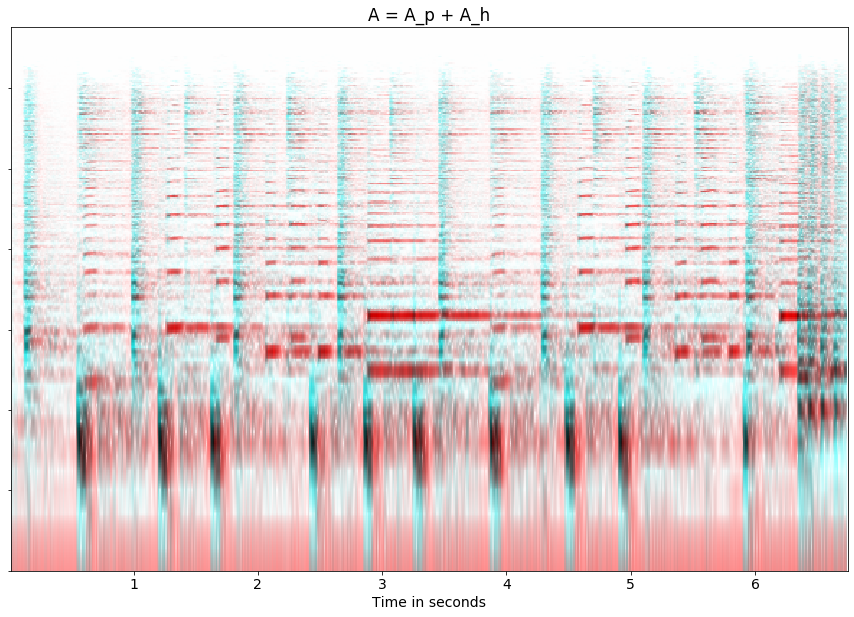

In [4]:
# set common parameters
numIterKAM = 30
kamA, Kern, KernOrd = HPSS_KAM_Fitzgerald(A, numIterKAM, 13)

# visualize
paramVis = dict()
paramVis['deltaT'] = deltaT
paramVis['deltaF'] = deltaF
paramVis['fontSize'] = 14

fh1 = visualizeComponentsKAM(kamA, paramVis)

# save result
fh1.savefig(os.path.join(outPath, 'demoDrumExtractionKAM_NMF_percThreshold_KAM.png'))

In [5]:
audios = []

# resynthesize KAM results
for k in range(2):
    Y = kamA[k] * np.exp(1j * P);
    y, _ = inverseSTFT(Y, paramSTFT)
    audios.append(y)
    # save result
    out_filepath = os.path.join(outPath,
                                'demoDrumExtractionKAM_NMF_percThreshold_KAM_component_{}_extracted_from_{}'.format(k, filename))
    
    wav.write(filename=out_filepath, rate=fs, data=y)

#### Input audio mixture

In [6]:
ipd.Audio(x, rate=fs)

#### KAM-based percussive component

In [7]:
ipd.Audio(audios[0].T, rate=fs)

#### KAM-based harmonic component

In [8]:
ipd.Audio(audios[1].T, rate=fs)

In [9]:
# concatenate new NMF target
V = np.concatenate([kamA[0], kamA[1]])
numDoubleBins = V.shape[0]

# prepare matrix to revert concatenation,
AccuMat = np.concatenate([np.eye(numBins), np.eye(numBins)], axis=1)

### 4. Apply score-informed NMF to KAM-based target

In [10]:
# set common parameters
numIterNMF = 60
numComp = 30
numTemplateFrames = 1

# generate random templates covering 2 times the original frequency range
paramTemplates = dict()
paramTemplates['numComp'] = numComp
paramTemplates['numBins'] = numDoubleBins
paramTemplates['numTemplateFrames'] = numTemplateFrames
initW = initTemplates(paramTemplates, 'random')

# generate uniform activations
paramActivations = dict()
paramActivations['numComp'] = numComp
paramActivations['numFrames'] = numFrames
initH = initActivations(paramActivations, 'uniform')

# set NMFD parameters
paramNMFD = dict()
paramNMFD['numComp'] = numComp
paramNMFD['numFrames'] = numFrames
paramNMFD['numIter'] = numIterNMF
paramNMFD['numTemplateFrames'] = numTemplateFrames
paramNMFD['numBins'] = numDoubleBins
paramNMFD['initW'] = initW
paramNMFD['initH'] = initH

# set soft constraint parameters
paramConstr = dict()
paramConstr['funcPointerPreProcess'] = drumSpecificSoftConstraintsNMF
paramConstr['Kern'] = Kern
paramConstr['KernOrd'] = KernOrd
paramConstr['decay'] = 0.75
paramConstr['numBinsDrum'] = numBins

# NMFD core method
nmfdW, nmfdH, _, _, tensorW = NMFD(V, paramNMFD, paramConstr)

# get final percussiveness estimate
percWeight = percussivenessEstimation(tensorW)

# re-order components, only for visualization
idx_sorted_rev = np.argsort(-percWeight)

tensorW = tensorW[:, idx_sorted_rev, :]
nmfdH = nmfdH[idx_sorted_rev, :]
nmfdW = [nmfdW[idx] for idx in idx_sorted_rev]
percWeight = percWeight[idx_sorted_rev]

# perform final thresholding
percWeight = np.where(percWeight > 0.25, 1.0, 0.0)

# compute separate models for percussive and harmonic part
# in the case of numTemplateFrames=1, this step equals eq. (1) in [2]
Vp = convModel(tensorW, np.diag(percWeight) @ nmfdH)
Vh = convModel(tensorW, np.diag(1 - percWeight) @ nmfdH)

# accumulate back to original spectrum, reverting the stacking
# this step is described in the last paragraph of sec. 2.4 in [2]
Ap = AccuMat @ Vp
Ah = AccuMat @ Vh

# alpha-Wiener filtering
nmfdA, _ = alphaWienerFilter(A, [Ap, Ah], 1)

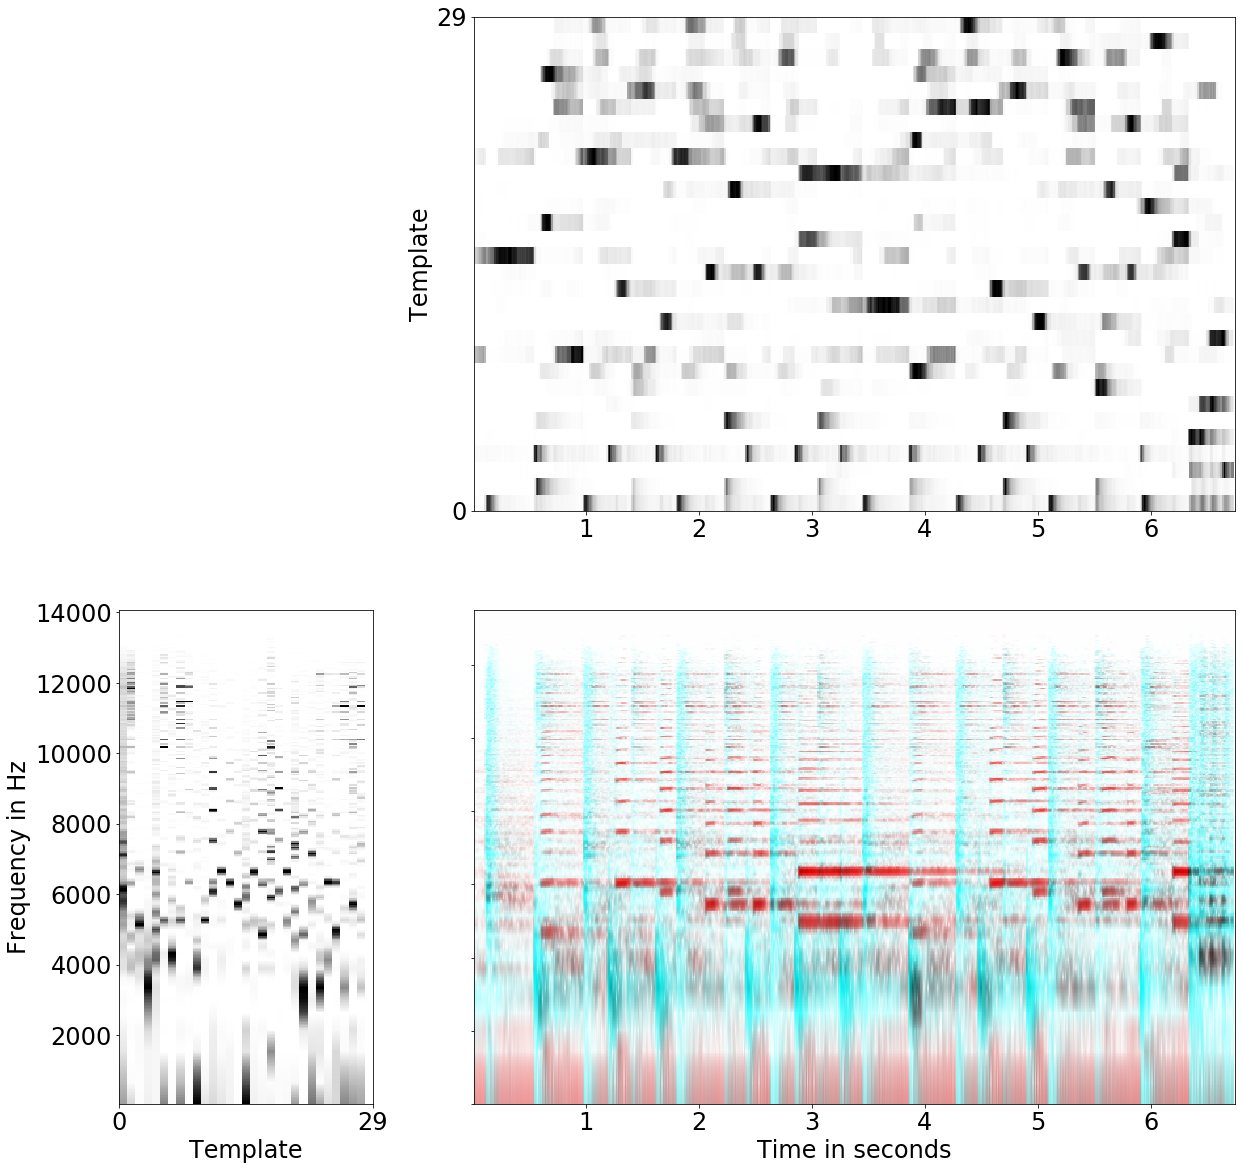

In [11]:
# create reduced version of templates for visualization
paramVis['fontSize'] = 24

nmfdW_vis = list()
for nmfdW_curr in nmfdW:
    nmfdW_curr = AccuMat @ nmfdW_curr
    nmfdW_vis.append(nmfdW_curr)

# nmfdW = AccuMat @ np.array(nmfdW).squeeze().T
fh2, _ = visualizeComponentsNMF(A, nmfdW_vis, nmfdH, nmfdA, paramVis);

# save result
fh2.savefig(os.path.join(outPath, 'demoDrumExtractionKAM_NMF_percThreshold_NMF.png'))

In [12]:
audios = []

# resynthesize NMF with soft constraints results
for k in range(2):
    Y = nmfdA[k] * np.exp(1j * P);
    y, _ = inverseSTFT(Y, paramSTFT)
    audios.append(y)
    
    # save result
    out_filepath = os.path.join(outPath,
                                'demoDrumExtractionKAM_NMF_percThreshold_NMF_component_{}_extracted_from_{}'.format(k, filename))
    
    wav.write(filename=out_filepath, rate=fs, data=y)

#### Input audio mixture

In [13]:
ipd.Audio(x, rate=fs)

#### Percussive component based on KAM + NMF

In [14]:
ipd.Audio(audios[0].T, rate=fs)

#### Harmonic component based on KAM + NMF

In [15]:
ipd.Audio(audios[1].T, rate=fs)